In [1]:
# Load environment variables and set up auto-reload
from dotenv import load_dotenv
load_dotenv()

%load_ext autoreload
%autoreload

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.utils import show_prompt
from src.prompt import supervisor_decision_to_route_to_subagents
show_prompt(supervisor_decision_to_route_to_subagents, "supervisor_decision_to_route_to_subagents")

c:\Users\kamalmo\Desktop\AI\InboundLogisticSystem\MultiAgentInboundLogistic\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


╭─────────────────────────────────── supervisor_decision_to_route_to_subagents ───────────────────────────────────╮
│                                                                                                                 │
│                                                                                                                 │
│  These are the inbound logistics Data received so far:                                                          │
│  <message>                                                                                                      │
│  {message}                                                                                                      │
│  </message>                                                                                                     │
│                                                                                                                 │
│  Today's date is {date}.                                                                                        │
│                                                                                                                 │
│  Your role is to act as the Supervisor Agent in the Inbound Logistics system.                                   │
│  Your responsibilities are:                                                                                     │
│  1. Assess the data provided by the user.                                                                       │
│  2. Decide whether the task should be delegated to:                                                             │
│     - `logistics_agent` → if the request relates to the following fields: {logistics_fields}. **Ensure any      │
│  provided data adheres to their `dataType` and `seededValues`, if provided.**                                   │
│     - `forwarder_agent` → if the request relates to the following fields: {forwarder_fields}. **Ensure any      │
│  provided data adheres to their `dataType` and `seededValues`, if provided.**                                   │
│  3. If the request is ambiguous or missing critical details, ask the user a **clarifying question** before      │
│  assigning the task.                                                                                            │
│  4. **Do not enforce field entry yourself — instead, delegate field-specific responsibilities to the            │
│  appropriate sub-agent (`logistics_agent` or `forwarder_agent`) based on {logistics_fields} and                 │
│  {forwarder_fields}.**                                                                                          │
│                                                                                                                 │
│  Guidelines for asking clarification:                                                                           │
│  - Only ask if **absolutely necessary**.                                                                        │
│  - Keep questions **concise and structured**. Use bullet points or lists if multiple clarifications are         │
│  needed.                                                                                                        │
│  - Do not repeat questions if the information is already provided.                                              │
│                                                                                                                 │
│  Respond in **valid JSON format** with these exact keys:                                                        │
│  - `"question"`: "<clarifying question used with <delegate_to=clarify_with_user> if necessary information is    │
│  needed, otherwise empty>"                                                                                      │
│  - `"delegate_to"`: "logistics_agent" | "forwarder_agent" | "supervisor_tools" | "clarify_with_user"            │
│  - `"agent_brief"`: "<acknowledgement message briefing

In [4]:
%%writefile ../src/supervisor_schema.py

"""Supervisor Definitions and Pydantic Schemas for Routing Workflow.

This defines the state objects and structured schemas used for Routing to 
sub agent sworkflow, including Supervisor state management and output schemas.
"""

import operator
from typing_extensions import Optional, Annotated, List, Sequence

from langchain_core.messages import BaseMessage
from langgraph.graph import MessagesState
from langgraph.graph.message import add_messages
from langchain_core.tools import tool, InjectedToolArg

from pydantic import BaseModel, Field
from enum import Enum

# ===== STRUCTURED OUTPUT SCHEMAS =====

class NextAgent(str, Enum):
    END = "__end__"
    CLARIFY_WITH_USER = "clarify_with_user"
    LOGISTICS_AGENT   = "logistics_agent"
    FORWARDER_AGENT   = "forwarder_agent"
    SUPERVISOR_TOOLS  = "supervisor_tools"
    
class ClarifyWithUser(BaseModel):
    """Schema for delegation decision and questions."""
    question: str = Field(
        description = "A question to ask the user to clarify the report scope",
    )
    delegate_to: NextAgent = Field(
        description = "A decision to delegate and route the task to the next agent",
    )
    agent_brief: str = Field(
        description = "A Brief that will be used to route the task to the next sub-agent",
    )
    
class AgentInputState(MessagesState):
    """Input state for the full agent - only contains messages from user input."""
    pass

class AgentState(MessagesState):
    """
    Main state for the full multi-agent system.
    
    Extends MessagesState with additional fields for routing coordination.
    """
    supervisor_messages: Annotated[Sequence[BaseMessage], add_messages]
    clarification_schemas: Optional[ClarifyWithUser] = None
    agent_brief: str

Overwriting ../src/supervisor_schema.py


In [5]:
%%writefile ../src/supervisor_agent.py

"""User Clarification and Routimg to Sub Agents.

This module implements the  the Routing workflow, where we:
1. Assess if the user's data needs clarification
2. Delegate and route to Sub Agents

The workflow uses structured output to make deterministic decisions about
whether sufficient context exists to proceed with Routing.
"""

import json
from datetime import datetime
from typing_extensions import Literal

from langchain.chat_models import init_chat_model
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage , get_buffer_string
from langgraph.graph import StateGraph, START, END
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver

from src.prompt import supervisor_decision_to_route_to_subagents
from src.supervisor_schema import AgentState, ClarifyWithUser, AgentInputState, NextAgent

checkpointer = InMemorySaver()


# ===== IBL FIELDS =====
try:
    with open ("../IBL_SCHEMA.json" , "r") as config_file:
        routing_fields = json.load(config_file)
except FileNotFoundError:
    print("Error: config.json not found. Please create it.")

# ===== UTILITY FUNCTIONS =====
def get_today_str() -> str:
    """Get current date in a human-readable format."""
    return datetime.now().strftime("%a %b %#d, %Y")

# Set up tools and model binding
tools = []
tools_by_name = {tool.name: tool for tool in tools}

# Initialize model
model = init_chat_model(model="openai:gpt-4.1", temperature=0.0)
model_with_tools = model.bind_tools(tools)


# ===== WORKFLOW NODES =====
def supervisor_agent(state: AgentState):
    """
        Supervisor Agent determines if the input data sufficient to make 
        deterministic decisions and assign the task to the next agent.
    """
    # Set up structured output model
    structured_output_model = model_with_tools.with_structured_output(ClarifyWithUser)

    # Invoke the model with clarification instructions
    response = structured_output_model.invoke([
        HumanMessage(content=supervisor_decision_to_route_to_subagents.format(
            message=get_buffer_string(messages=state["messages"]), 
            date=get_today_str(),
            logistics_fields=routing_fields.get("logistics_agent"),
            forwarder_fields=routing_fields.get("forwarder_agent")
        ))
    ])
    
    # Route based on clarification need
    return {
             "clarification_schemas" : response ,
             "agent_brief" : response.agent_brief,
             "supervisor_messages": [
                                    AIMessage(content=response.delegate_to.value)
                                    ]
           }

def supervisor_tools(state: AgentState):
    """
        Executes all tool calls from the Supervisor Agent response.
        Returns updated state with tool execution results.
    """
    tool_calls = state["supervisor_messages"][-1].tool_calls
 
    # Execute all tool calls
    observations = []
    for tool_call in tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observations.append(tool.invoke(tool_call["args"]))
            
    # Create tool message outputs
    tool_outputs = [
        ToolMessage(
            content=observation,
            name=tool_call["name"],
            tool_call_id=tool_call["id"]
        ) for observation, tool_call in zip(observations, tool_calls)
    ]
    
    return {"supervisor_messages": tool_outputs}

def clarify_with_user(state: AgentState):
    """In Case the user needs to be asked a clarifying question."""
    clarification_schemas = state.get("clarification_schemas")
    if clarification_schemas and clarification_schemas.question:
        question = clarification_schemas.question
    return {"messages": [AIMessage(content=question)]}

def DelegateNextAgent(state: AgentState) -> Literal["logistics_agent", "forwarder_agent", "supervisor_tools", "clarify_with_user"]:
    
    """ 
        A routing logic that uses the supervisor agent's responses to determine 
        which agent should be assigned the task next 
    """

    # Then check the routing decision
    clarification_schemas = state.get("clarification_schemas")
    if not clarification_schemas:
        return "__end__"

    if clarification_schemas.delegate_to == NextAgent.LOGISTICS_AGENT:
        return "logistics_agent"
    elif clarification_schemas.delegate_to == NextAgent.FORWARDER_AGENT:
        return "forwarder_agent"
    elif clarification_schemas.delegate_to == NextAgent.CLARIFY_WITH_USER:
        return "clarify_with_user"
    else:
        return "__end__"

def logistics_agent(state: AgentState):
    pass

def forwarder_agent(state: AgentState):
    pass

# ===== GRAPH CONSTRUCTION =====

# Build the scoping workflow
supervisor_agent_builder = StateGraph(AgentState, input_schema=AgentInputState)

# Add workflow nodes
supervisor_agent_builder.add_node("supervisor_agent", supervisor_agent)
supervisor_agent_builder.add_node("supervisor_tools", supervisor_tools)
supervisor_agent_builder.add_node("clarify_with_user", clarify_with_user)
supervisor_agent_builder.add_node("logistics_agent", logistics_agent)
supervisor_agent_builder.add_node("forwarder_agent", forwarder_agent)

# Add workflow edges
supervisor_agent_builder.add_edge(START, "supervisor_agent")
supervisor_agent_builder.add_conditional_edges(
    "supervisor_agent",
     DelegateNextAgent,
    {
        "supervisor_tools" : "supervisor_tools"  , # execute tools,
        "clarify_with_user": "clarify_with_user" , # Provide final answer
        "logistics_agent"  : "logistics_agent" ,
        "forwarder_agent"  : "forwarder_agent"
    },
)
supervisor_agent_builder.add_edge("supervisor_tools", "supervisor_agent")
supervisor_agent_builder.add_edge("clarify_with_user", END)

# Compile the workflow
SupervisorAgent = supervisor_agent_builder.compile(checkpointer = checkpointer)

Overwriting ../src/supervisor_agent.py


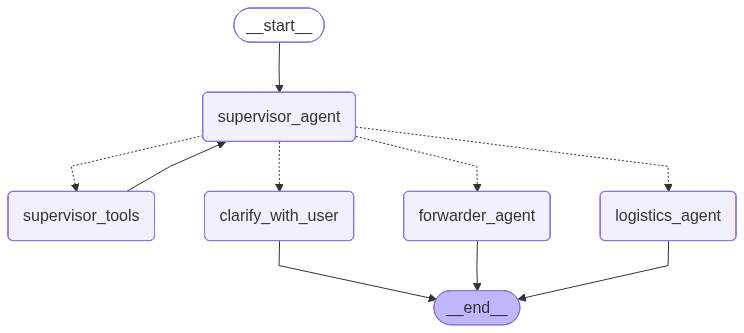

In [6]:
# Compile with in-memory checkpointer to test in notebook
from IPython.display import Image, display
from src.supervisor_agent import SupervisorAgent

display(Image(SupervisorAgent.get_graph(xray=True).draw_mermaid_png()))

In [7]:
from src.utils import format_message
from langchain_core.messages import HumanMessage
thread = {"configurable":{"thread_id":"1"}}
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="I want to enter the AWB# 12345 and AWB Date")]} , config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB# 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='5c272b61-4458-48ce-ada9-6196b7db477b'),
  AIMessage(content='You mentioned you want to enter the AWB Date. Could you please provide the specific date (in YYYY-MM-DD format) for the AWB# 12345?', additional_kwargs={}, response_metadata={}, id='7497943b-2117-48a6-93ce-d0b864c2c7cc')],
 'supervisor_messages': [AIMessage(content='clarify_with_user', additional_kwargs={}, response_metadata={}, id='64d51f1c-2ae7-40a8-ad2b-9a5aa7f03af7')],
 'clarification_schemas': ClarifyWithUser(question='You mentioned you want to enter the AWB Date. Could you please provide the specific date (in YYYY-MM-DD format) for the AWB# 12345?', delegate_to=<NextAgent.CLARIFY_WITH_USER: 'clarify_with_user'>, agent_brief=''),
 'agent_brief': ''}

In [8]:
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Well the AWB# is 12345 and AWB Date 72025-08-12")]}, config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB# 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='e957e5d7-4370-4592-8739-729b54c2b9b9'),
  AIMessage(content='Please provide the AWB Date in YYYY-MM-DD format to proceed with the entry.', additional_kwargs={}, response_metadata={}, id='3de66273-158a-4f7f-9454-b348d176162a'),
  HumanMessage(content='Well the AWB# is 12345 and AWB Date 72025-08-12', additional_kwargs={}, response_metadata={}, id='622ed469-39eb-40d8-8cf0-67152ea873a0'),
  AIMessage(content="The provided AWB Date '72025-08-12' appears to be in the future and may be a typo. Please confirm the correct AWB Date in YYYY-MM-DD format.", additional_kwargs={}, response_metadata={}, id='4369174a-7963-41d3-a2ff-21cd49d01b95')],
 'supervisor_messages': [AIMessage(content='clarify_with_user', additional_kwargs={}, response_metadata={}, id='4cef6e8e-95f1-4942-868b-24481d650dc8'),
  AIMessage(content='clarify_with_user', additional_kwargs={}, response_meta

In [8]:
result = SupervisorAgent.invoke({"messages":[HumanMessage(content="Well the AWB# is 12345 and AWB Date 2025-08-12")]}, config=thread)
result

{'messages': [HumanMessage(content='I want to enter the AWB# 12345 and AWB Date', additional_kwargs={}, response_metadata={}, id='5c272b61-4458-48ce-ada9-6196b7db477b'),
  AIMessage(content='You mentioned you want to enter the AWB Date. Could you please provide the specific date (in YYYY-MM-DD format) for the AWB# 12345?', additional_kwargs={}, response_metadata={}, id='7497943b-2117-48a6-93ce-d0b864c2c7cc'),
  HumanMessage(content='Well the AWB# is 12345 and AWB Date 2025-08-12', additional_kwargs={}, response_metadata={}, id='67791be8-d610-48df-b17f-af0b8106a114')],
 'supervisor_messages': [AIMessage(content='clarify_with_user', additional_kwargs={}, response_metadata={}, id='64d51f1c-2ae7-40a8-ad2b-9a5aa7f03af7'),
  AIMessage(content='logistics_agent', additional_kwargs={}, response_metadata={}, id='29446571-4f08-4646-b979-56228dcb427d')],
 'clarification_schemas': ClarifyWithUser(question='', delegate_to=<NextAgent.LOGISTICS_AGENT: 'logistics_agent'>, agent_brief='The input data in